In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import random

### 1.了解深度学习常见的激活函数

In [3]:
def use_svg_display():
    # 用矢量图显示
    %config InlineBackend.figure_format = 'svg'

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

def xyplot(x_vals, y_vals, name):
    set_figsize(figsize=(5, 2.5))
    plt.plot(x_vals.numpy(), y_vals.numpy())
    plt.xlabel('x')
    plt.ylabel(name + '(x)')

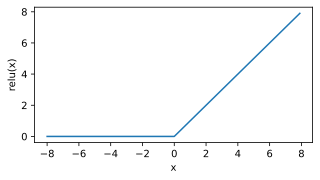

In [4]:
x = tf.Variable(tf.range(-8,8,0.1),dtype=tf.float32)
y = tf.nn.relu(x) #tf.math.maximum(x,0)
xyplot(x, y, 'relu')

绘制ReLU函数的导数

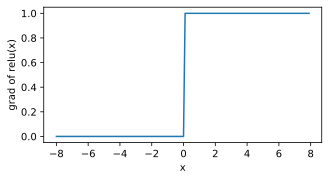

In [6]:
with tf.GradientTape() as t:
    t.watch(x)
    y = tf.nn.relu(x)
dy_dx = t.gradient(y,x)
xyplot(x, dy_dx, 'grad of relu')

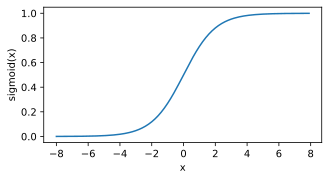

In [5]:
y = tf.nn.sigmoid(x)
xyplot(x, y, 'sigmoid')

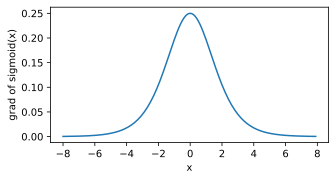

In [7]:
with tf.GradientTape() as t:
    t.watch(x)
    y = tf.nn.sigmoid(x)
dy_dx = t.gradient(y,x)
xyplot(x, dy_dx, 'grad of sigmoid')

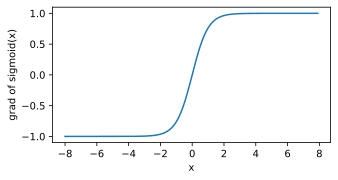

In [8]:
y = tf.nn.tanh(x)
xyplot(x, y, 'grad of tanh')

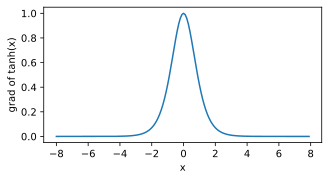

In [10]:
with tf.GradientTape() as t:
    t.watch(x)
    y = tf.nn.tanh(x)
dy_dx = t.gradient(y,x)
xyplot(x, dy_dx, 'grad of tanh')

## 2.制作tf的数据集

In [ ]:
train_iter = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
test_iter = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

## 3.模型选择、欠拟合和过拟合

3.1应对过拟合问题的常用方法：权重衰减（weight decay）
- 权重衰减等价于L_2范数正则化（regularization）。正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段。

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models, initializers, optimizers, regularizers
import numpy as np
import matplotlib.pyplot as plt

In [13]:
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = tf.ones((num_inputs,1))*0.01, 0.05
features = tf.random.normal(shape=(n_train + n_test, num_inputs))
labels = tf.keras.backend.dot(features, true_w) + true_b
labels += tf.random.normal(mean=0.01, shape=labels.shape)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

手工搭建

In [14]:
def init_params():
    w = tf.Variable(tf.random.normal(mean=1, shape=(num_inputs, 1)))
    b = tf.Variable(tf.zeros(shape=(1,)))
    return [w,b]

In [15]:
def l2_penalty(w):
    return tf.reduce_sum((w**2))/2

In [16]:
def linreg(x,w,b):
    return tf.matmul(x,w) + b

In [17]:
def squared_loss(y_hat, y):
    return (y_hat - tf.reshape(y, y_hat.shape)) ** 2 /2

In [20]:
def sgd(params, lr, batch_size, grads):
    """Mini-batch stochastic gradient descent."""
    for i, param in enumerate(params):
        param.assign_sub(lr * grads[i]/batch_size)#不改变内存地址上进行更新

In [27]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)
    plt.show()

In [24]:
batch_size, num_epochs, lr = 1, 100, 0.003

net, loss = linreg, squared_loss
optimizer = tf.keras.optimizers.SGD()
train_iter = tf.data.Dataset.from_tensor_slices(
    (train_features, train_labels)).batch(batch_size).shuffle(batch_size)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape(persistent=True) as tape:
                # 添加了L2范数惩罚项
                l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            grads = tape.gradient(l, [w, b])
            sgd([w, b], lr, batch_size, grads)
        train_ls.append(tf.reduce_mean(loss(net(train_features, w, b),
                             train_labels)).numpy())
        test_ls.append(tf.reduce_mean(loss(net(test_features, w, b),
                            test_labels)).numpy())
    print('L2 norm of w:', tf.norm(w).numpy())

In [25]:
fit_and_plot(lambd=0)

L2 norm of w: 19.156507


使用权重衰减

In [26]:
fit_and_plot(lambd=3)

L2 norm of w: 0.23012571


简洁实现
- 在 TensorFlow2.0 中，我们可以对Dense层传入 kernel_regularizer 参数进行权重衰减。

In [33]:
def fit_and_plot_tf2(wd, lr=1e-3):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(1, kernel_regularizer=regularizers.l2(wd), bias_regularizer=None)
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=lr), 
                  loss=tf.keras.losses.MeanSquaredError())
    history = model.fit(train_features, train_labels, epochs=100, batch_size=1, 
                        validation_data=(test_features, test_labels),
                        validation_freq=1,verbose=0)
    train_ls = history.history['loss']
    test_ls = history.history['val_loss']
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                     range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', tf.norm(model.get_weights()[0]).numpy())

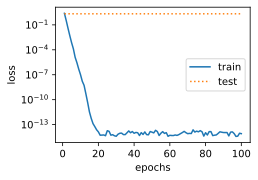

L2 norm of w: 1.3861855


In [34]:
fit_and_plot_tf2(0, lr)

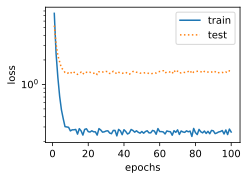

L2 norm of w: 0.25844756


In [35]:
fit_and_plot_tf2(3, lr)

3.2 丢弃法
- 丢弃法不改变其输入的期望值，训练过程中随机弃用某些隐藏层神经单元，隐藏单元相关的权重的梯度均为0。
- 在测试模型时，我们为了拿到更加确定性的结果，一般不使用丢弃法。
- 我们可以通过使用丢弃法应对过拟合。
- 丢弃法只在训练模型时使用。

In [38]:
import tensorflow as tf
import numpy as np
from tensorflow import keras, nn, losses
from tensorflow.keras.layers import Dropout, Flatten, Dense

dropout函数将以drop_prob的概率丢弃X中的元素。

In [41]:
def dropout(X, drop_prob):
    assert 0 <= drop_prob <= 1
    keep_prob = 1 - drop_prob
    # 这种情况下把全部元素都丢弃
    if keep_prob == 0:
        return tf.zeros_like(X)
    #初始mask为一个bool型数组，故需要强制类型转换
    mask = tf.random.uniform(shape=X.shape, minval=0, maxval=1) < keep_prob
    return tf.cast(mask, dtype=tf.float32) * tf.cast(X, dtype=tf.float32) / keep_prob

In [42]:
X = tf.reshape(tf.range(0, 16), shape=(2, 8))


In [43]:
dropout(X, 0)

<tf.Tensor: shape=(2, 8), dtype=float32, numpy=
array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11., 12., 13., 14., 15.]], dtype=float32)>

In [44]:
dropout(X, 0.5)

<tf.Tensor: shape=(2, 8), dtype=float32, numpy=
array([[ 0.,  0.,  0.,  6.,  8.,  0., 12., 14.],
       [ 0.,  0., 20.,  0., 24.,  0., 28., 30.]], dtype=float32)>

In [45]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

W1 = tf.Variable(tf.random.normal(stddev=0.01, shape=(num_inputs, num_hiddens1)))
b1 = tf.Variable(tf.zeros(num_hiddens1))
W2 = tf.Variable(tf.random.normal(stddev=0.1, shape=(num_hiddens1, num_hiddens2)))
b2 = tf.Variable(tf.zeros(num_hiddens2))
W3 = tf.Variable(tf.random.truncated_normal(stddev=0.01, shape=(num_hiddens2, num_outputs)))
b3 = tf.Variable(tf.zeros(num_outputs))

params = [W1, b1, W2, b2, W3, b3]

下面定义的模型将全连接层和激活函数ReLU串起来，并对每个激活函数的输出使用丢弃法。

我们可以分别设置各个层的丢弃概率。通常的建议是把靠近输入层的丢弃概率设得小一点。

我们可以通过参数is_training函数来判断运行模式为训练还是测试，并只需在训练模式下使用丢弃法。

In [ ]:
drop_prob1, drop_prob2 = 0.2, 0.5

def net(X, is_training=False):
    X = tf.reshape(X, shape=(-1,num_inputs))
    H1 = tf.nn.relu(tf.matmul(X, W1) + b1)
    if is_training:# 只在训练模型时使用丢弃法
        H1 = dropout(H1, drop_prob1)  # 在第一层全连接后添加丢弃层
    H2 = nn.relu(tf.matmul(H1, W2) + b2)
    if is_training:
        H2 = dropout(H2, drop_prob2)  # 在第二层全连接后添加丢弃层
    return tf.math.softmax(tf.matmul(H2, W3) + b3)

In [ ]:
from tensorflow.keras.datasets import fashion_mnist

def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for _, (X, y) in enumerate(data_iter):
        y = tf.cast(y,dtype=tf.int64)
        acc_sum += np.sum(tf.cast(tf.argmax(net(X), axis=1), dtype=tf.int64) == y)
        n += y.shape[0]
    return acc_sum / n

def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, trainer=None):
    global sample_grads
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                y_hat = net(X, is_training=True)
                l = loss(y_hat, tf.one_hot(y, depth=10, axis=-1, dtype=tf.float32))
            
            grads = tape.gradient(l, params)
            if trainer is None:
                
                sample_grads = grads
                params[0].assign_sub(grads[0] * lr)
                params[1].assign_sub(grads[1] * lr)
            else:
                trainer.apply_gradients(zip(grads, params))  # “softmax回归的简洁实现”一节将用到

            y = tf.cast(y, dtype=tf.float32)
            train_l_sum += l.numpy()
            train_acc_sum += tf.reduce_sum(tf.cast(tf.argmax(y_hat, axis=1) == tf.cast(y, dtype=tf.int64), dtype=tf.int64)).numpy()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

        
loss = tf.losses.CategoricalCrossentropy()
num_epochs, lr, batch_size = 5, 0.5, 256
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = tf.cast(x_train, tf.float32) / 255 #在进行矩阵相乘时需要float型，故强制类型转换为float型
x_test = tf.cast(x_test,tf.float32) / 255 #在进行矩阵相乘时需要float型，故强制类型转换为float型
train_iter = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
test_iter = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params, lr)

简洁实现

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(256,activation='relu'),
    Dropout(0.2),
    keras.layers.Dense(256,activation='relu'),
    Dropout(0.5),
    keras.layers.Dense(10,activation=tf.nn.softmax)
])
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train,y_train,epochs=5,batch_size=256,validation_data=(x_test, y_test),
                    validation_freq=1)